In [1]:
import numpy as np
import IPython as ipython

sample_rate = 16_000  # values / second
length = 4            # seconds
frequency = 400       # Hz

# time axis from 0 to 4 seconds with a total of 4 x 16k values
x = np.linspace(
    start=0,
    stop=length,
    num=sample_rate * length
)
# Construct a sine wave
radian_x = x * 2 * np.pi
y = np.sin(radian_x * frequency)

# Display
ipython.display.Audio(y, rate=sample_rate)


Text(0.5, 0, 'time (s)')

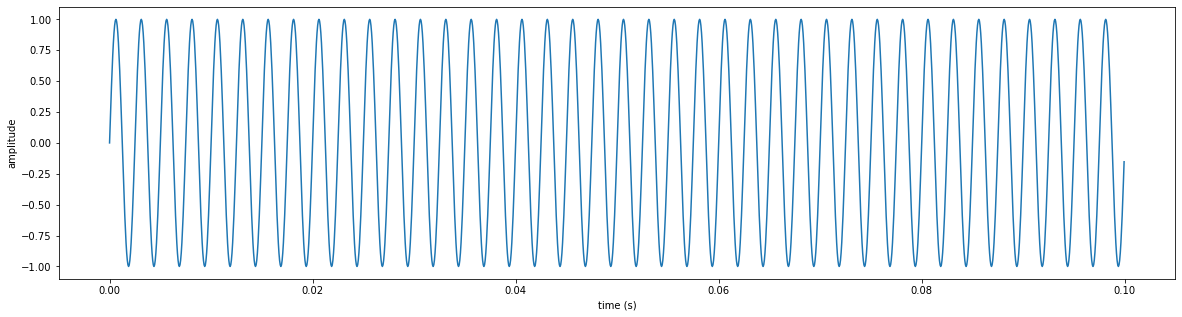

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 5))
sample_size = int(sample_rate * 0.1)  # 0.1 second
sample_x = x[: sample_size]
sample_y = y[: sample_size]
plt.plot(
    sample_x,
    sample_y
)
plt.ylabel('amplitude')
plt.xlabel('time (s)')


Text(0, 0.5, 'Intensity')

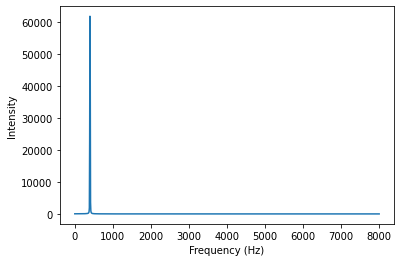

In [3]:
import librosa

intensities = np.abs(librosa.stft(y)).sum(axis=1)
frequencies = librosa.fft_frequencies(sample_rate)

plt.plot(frequencies, intensities)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Intensity')


c:\users\david.isaacspaternos\anaconda3\envs\testnsynth\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\david.isaacspaternos\anaconda3\envs\testnsynth\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\david.isaacspaternos\anaconda3\envs\testnsynth\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


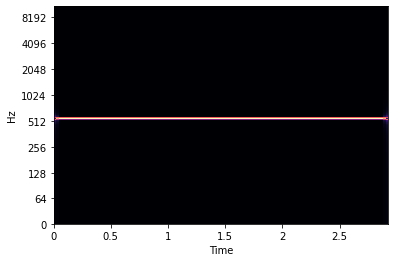

In [4]:
from librosa import display

spectrogram = np.abs(librosa.stft(y))
librosa.display.specshow(spectrogram, y_axis='log', x_axis='time')


In [17]:
import tensorflow as tf


def _one_hot(tensor: tf.Tensor, size) -> tf.Tensor:
    """
    One hot encode a tensor and return it as 1D tensor
    :param tensor:
    :param size: number of unique values in tensor
    :return:
    """
    hot_tensor = tf.one_hot(tensor, size)
    shaped_tensor = tf.reshape(hot_tensor, (size,))
    return shaped_tensor


@tf.autograph.experimental.do_not_convert
def _parse_function(example_proto):
    # Schema
    features = {
        "pitch": tf.io.FixedLenFeature([1], dtype=tf.int64),
        "audio": tf.io.FixedLenFeature([64000], dtype=tf.float32)
    }
    example = tf.io.parse_single_example(example_proto, features)
    data = example['audio']
    label_name = 'pitch'
    label_value_count = 128
    label = _one_hot(example[label_name], label_value_count)
    return data, label


path_to_train_data = '../data/tfrecords/nsynth-train.tfrecord'

train_dataset = tf.data \
        .TFRecordDataset(path_to_train_data) \
        .map(_parse_function) \
        .batch(128)

path_to_test_data = '../data/tfrecords/nsynth-valid.tfrecord'

test_dataset = tf.data \
        .TFRecordDataset(path_to_test_data) \
        .map(_parse_function) \
        .batch(128)



In [18]:
import tensorflow as tf
from keras import layers
audio_length = sample_rate*length
model = tf.keras.Sequential([
    layers.Input(shape=(audio_length,)),
    layers.Reshape(target_shape=(audio_length, 1)),
    layers.Conv1D(4, 9, activation='relu'),
    layers.AveragePooling1D(4),
    layers.Conv1D(8, 9, activation='relu'),
    layers.AveragePooling1D(4),
    layers.Conv1D(12, 9, activation='relu'),
    layers.AveragePooling1D(4),
    layers.Conv1D(16, 9, activation='relu'),
    layers.AveragePooling1D(4),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='softmax')
])
